# Úvod
Cieľom tohto projektu je vytvorenie a vyhodnotenie modelu strojového učenia, ktorý dokáže na základe chemických vlastností vína predikovať jeho kvalitu. V praxi ide o typickú úlohu, s ktorou sa stretávajú vinári, výrobcovia aj obchodníci – potrebujú vedieť, ako sa konkrétne parametre nápoja premietnu do výsledného hodnotenia kvality. Strojové učenie umožňuje tieto vzťahy zachytiť automatizovaným spôsobom a na základe historických dát odhadovať kvalitu nových vzoriek vína.

V projekte pracujem s verejne dostupným datasetom „Wine Quality“ z portálu Kaggle, ktorý obsahuje fyzikálno-chemické merania červeného vína (napr. obsah alkoholu, prchavú kyslosť, množstvo síranov, cukru či oxidov síry) a k nim priradené číselné hodnotenie kvality udelené odborníkmi. Každý riadok datasetu predstavuje jednu vzorku vína a jednotlivé stĺpce zodpovedajú buď vstupným premenným, alebo cieľovej premennej – hodnoteniu kvality na škále od 3 do 8.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Zdroj kódu

https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/data

In [2]:
df = pd.read_csv("datasety/archive3/winequality-red.csv")

In [3]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Premenné

## Nezávislé premenné

- **Fixed acidity (fixná / neprchavá kyslosť)** – väčšina kyselín vo víne je fixná alebo neprchavá (neodparuje sa ľahko). Typické hodnoty sa pohybujú približne v rozmedzí **4,5 až 8,5 g/l**.

- **Volatile acidity (prchavá kyslosť)** – množstvo kyseliny octovej vo víne; pri príliš vysokých hodnotách môže spôsobiť nepríjemnú octovú chuť. Horná hranica pre bežné tiché vína je približne **1,2 g/l** (v prepočte na kyselinu octovú) a pre veľmi sladké vína typu *noble rot* približne **2,1 g/l**.

- **Citric acid (kyselina citrónová)** – vyskytuje sa vo víne v malom množstve, ale môže dodávať „sviežosť“ a zvýrazniť chuť. Typické hodnoty sú **0,1 – 0,7 g/l**.

- **Residual sugar (zvyškový cukor)** – množstvo cukru, ktoré zostane po ukončení fermentácie. Vína s menej ako **1 g/l** sú skôr výnimočné, naopak vína s viac ako **45 g/l** sa považujú za sladké.

- **Chlorides (chloridy / obsah soli)** – množstvo solí (najmä chloridu sodného) vo víne. Bežné hodnoty sa pohybujú približne v rozmedzí **20 – 500 mg/l**, niektoré vína môžu mať aj vyššie koncentrácie.

- **Free sulfur dioxide (voľný oxid siričitý, free SO₂)** – voľná forma SO₂ existujúca v rovnováhe medzi molekulárnym SO₂ (rozpustený plyn) a hydrogénsiřičitanovým iónom. Chráni víno pred mikrobiálnym rastom a oxidáciou. Typické hodnoty sú približne **25 – 50 mg/l**, pri niektorých vínach **70 – 90 mg/l**.

- **Total sulfur dioxide (celkový oxid siričitý, total SO₂)** – súčet voľných a viazaných foriem SO₂. Pri nízkych koncentráciách je zmyslami takmer nepostrehnuteľný, ale pri voľnom SO₂ nad **50 ppm** je už badateľný v aróme a chuti. Horné limity sa podľa typu vína a legislatívy pohybujú približne v rozmedzí **150 – 400 mg/l**.

- **Density (hustota)** – hustota vína, ktorá je blízka hustote vody a závisí najmä od obsahu alkoholu a cukru.

- **pH (pH, kyslosť/zásaditosť)** – ukazovateľ toho, ako kyslé alebo zásadité je víno. Väčšina vín má pH približne **3 – 4** (kyslá oblasť škály).

- **Sulphates (sírany)** – látky na báze síranov, ktoré môžu prispievať k tvorbe oxidu siričitého (SO₂). Ten pôsobí ako antioxidant a antimikrobiálna prísada. Typické hodnoty sú približne **5 – 400 mg/l**, v EÚ je zákonný limit až do **2,5 g/l**.

- **Alcohol (alkohol)** – objemový podiel etanolu vo víne, zvyčajne vyjadrený v percentách objemu (% obj.).

## Závislá premenná

- **Quality (kvalita)** – senzorické hodnotenie kvality vína na číselnej škále, teoreticky **0 – 10**; v použitom datasete sa hodnoty pohybujú približne **od 3 do 8**.


In [4]:
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

Opisné štatistiky ukazujú, že dataset je kompletný – všetky premenné majú 1599 pozorovaní, takže sa nevyskytujú chýbajúce hodnoty. Väčšina chemických parametrov sa pohybuje v realistických rozsahoch pre červené víno: priemerná fixná kyslosť je okolo 8,3 g/l, prchavá kyslosť približne 0,53 g/l a kyselina citrónová asi 0,28 g/l. Hustota je blízko hodnoty 0,997, čo zodpovedá vodno-alkoholickému roztoku, a pH sa pohybuje medzi 2,7 a 4,0 s priemerom približne 3,3, čo je typické pre kyslosť vína. Pri alkohole vidno priemernú hodnotu okolo 10,4 % s rozpätím približne od 8,4 do 14,9 %.

Niektoré premenné (najmä zvyškový cukor, total sulfur dioxide a sulphates) majú pomerne nízke kvartily, ale výrazne vyššie maximá, čo naznačuje prítomnosť niekoľkých extrémnych hodnôt. Cieľová premenná quality má priemer približne 5,6, medián 6 a hodnoty v intervale od 3 do 8, takže väčšina vzoriek predstavuje vína priemernej až mierne nadpriemernej kvality; extrémne nízke ani veľmi vysoké hodnotenia sa v súbore vyskytujú len zriedka.

fixed acidity              Axes(0.125,0.712609;0.227941x0.167391)
volatile acidity        Axes(0.398529,0.712609;0.227941x0.167391)
citric acid             Axes(0.672059,0.712609;0.227941x0.167391)
residual sugar             Axes(0.125,0.511739;0.227941x0.167391)
chlorides               Axes(0.398529,0.511739;0.227941x0.167391)
free sulfur dioxide     Axes(0.672059,0.511739;0.227941x0.167391)
total sulfur dioxide        Axes(0.125,0.31087;0.227941x0.167391)
density                  Axes(0.398529,0.31087;0.227941x0.167391)
pH                       Axes(0.672059,0.31087;0.227941x0.167391)
sulphates                      Axes(0.125,0.11;0.227941x0.167391)
alcohol                     Axes(0.398529,0.11;0.227941x0.167391)
quality                     Axes(0.672059,0.11;0.227941x0.167391)
dtype: object

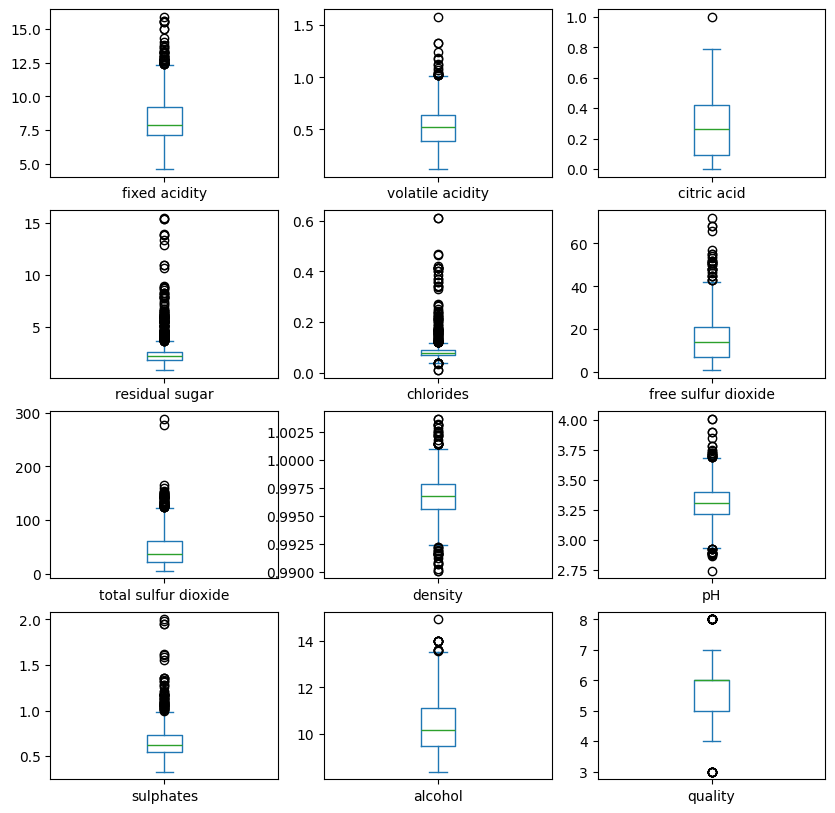

In [5]:
df.plot(kind = "box", subplots= True, layout = (4,3), figsize = (10,10))

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

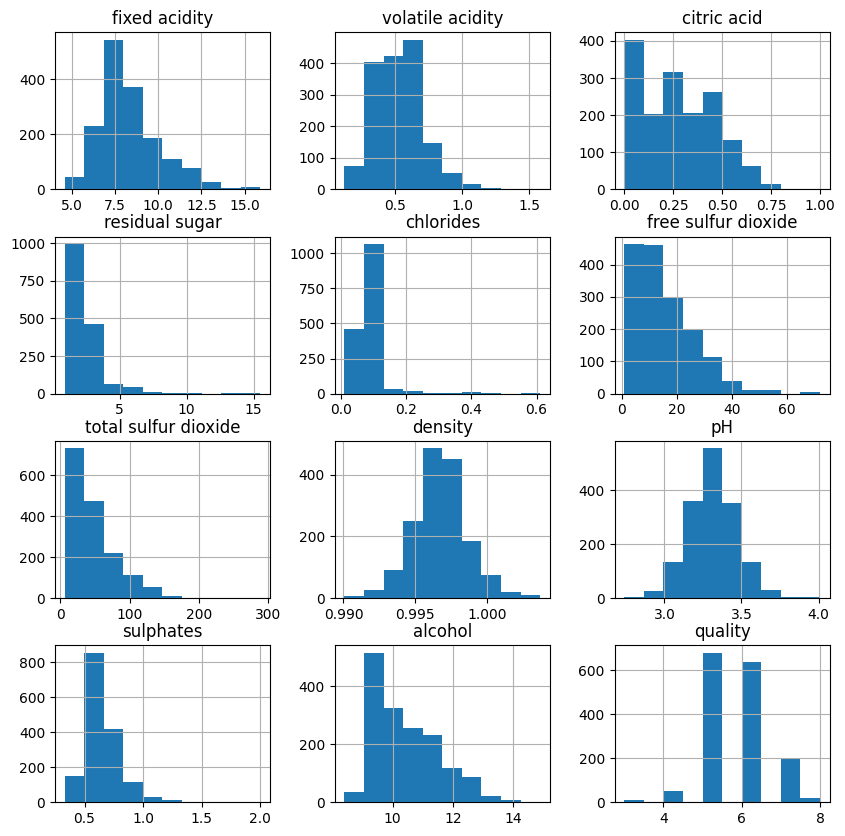

In [6]:
df.hist(figsize = (10,10))

Histogramy ukazujú, že väčšina premenných má pomerne jasné „typické“ rozsahy hodnôt a pri viacerých z nich sa objavuje výrazné zošikmenie doprava. Premenné fixed acidity, volatile acidity a citric acid majú rozdelenia sústredené okolo jednej dominantnej oblasti (okolo 7–8 g/l pri fixed acidity, okolo 0,5 pri volatile acidity a okolo 0,2–0,3 pri citric acid) a smerom k vyšším hodnotám postupne ubúda pozorovaní. Ešte výraznejšie je to pri residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide a sulphates – väčšina vín má nízke až stredné hodnoty týchto premenných, ale malé množstvo vín má veľmi vysoké hodnoty, čo sa prejavuje dlhým pravým chvostom rozdelenia.

Premenné density a pH sú naopak veľmi koncentrované – hustota sa pohybuje vo veľmi úzkom intervale okolo 0,996–0,998 a pH má približne zvonovitý tvar so stredom okolo 3,3, čo je typické pre červené vína. Pri alcohol je vidieť, že väčšina vín má obsah alkoholu približne medzi 9 a 12 %, pričom veľmi silné vína (nad 13–14 %) sú skôr výnimkou. Cieľová premenná quality má rozdelenie sústredené najmä na hodnotách 5 a 6, čo potvrdzuje, že dataset obsahuje predovšetkým vína priemernej až mierne nadpriemernej kvality, zatiaľ čo veľmi nízke či veľmi vysoké hodnotenia sa vyskytujú len zriedka. Celkovo histogramy ukazujú, že niektoré premenné majú pomerne výrazné extrémy a silné zošikmenie

In [7]:
corr = df.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


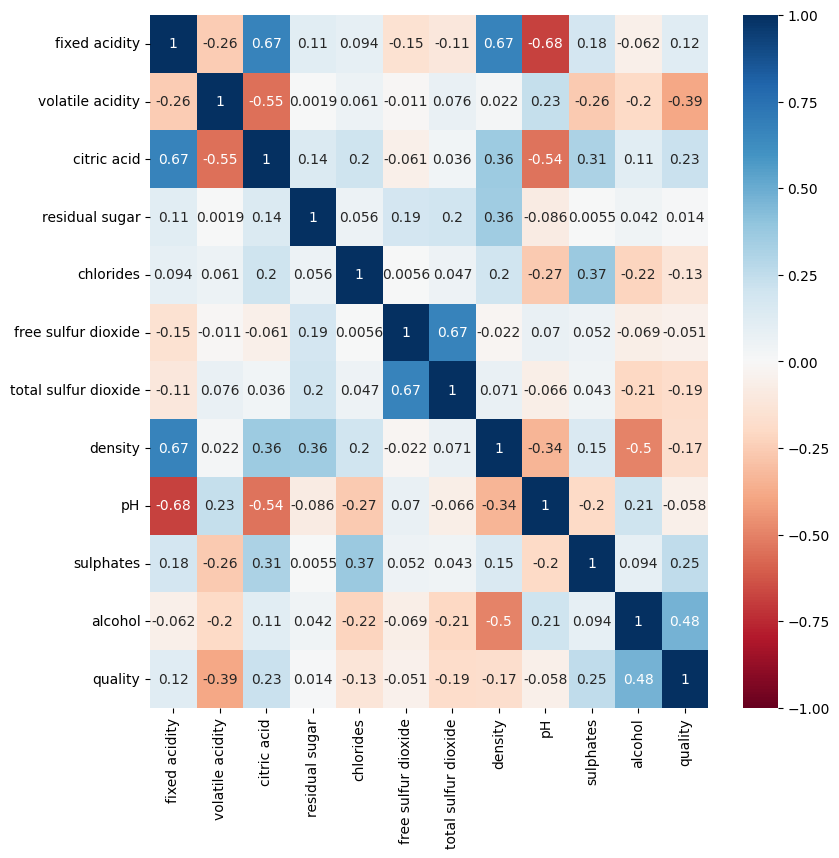

In [8]:
plt.figure(figsize = (9,9))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.show()

In [9]:
# najhorsie korelacie
df_wine_X = df.drop(columns=["quality"])
df_wine_X
corr_matrix = df_wine_X.corr().abs() # Use absolute values
upper_triangle_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_triangle_corr = corr_matrix.where(upper_triangle_mask)
corr_series = upper_triangle_corr.stack().dropna()
top_correlations = corr_series.sort_values(ascending=False).head(10)
print(f'Najsilnejšie absolútne  korelácie:\n{top_correlations}')

Najsilnejšie absolútne  korelácie:
fixed acidity        pH                      0.682978
                     citric acid             0.671703
                     density                 0.668047
free sulfur dioxide  total sulfur dioxide    0.667666
volatile acidity     citric acid             0.552496
citric acid          pH                      0.541904
density              alcohol                 0.496180
chlorides            sulphates               0.371260
citric acid          density                 0.364947
residual sugar       density                 0.355283
dtype: float64


Korelačná matica ukazuje, že kvalita vína súvisí s viacerými chemickými parametrami, ale väzby sú väčšinou skôr stredne silné.
Najsilnejšia pozitívna korelácia s kvalitou je pri premennej alcohol (≈ 0,48) – vyšší obsah alkoholu je teda typicky spojený s vyšším hodnotením vína. Ďalej nasledujú sulphates (≈ 0,25) a citric acid (≈ 0,23), ktoré tiež mierne pozitívne súvisia s kvalitou. Naopak, najsilnejšia negatívna korelácia je pri volatile acidity (≈ −0,39), takže vyššia prchavá kyslosť je typická skôr pre vína nižšej kvality. Slabšie negatívne vzťahy s kvalitou majú aj chlorides, total sulfur dioxide a density, väčšina ostatných premenných má s kvalitou len veľmi slabú koreláciu.

Medzi vysvetľujúcimi premennými navzájom vidno niekoľko silnejších vzťahov, napríklad fixed acidity výrazne koreluje s citric acid a density, a zároveň negatívne s pH. Hustota je zas výraznejšie negatívne korelovaná s obsahom alkoholu. To naznačuje určitú mieru multikolinearity, s ktorou treba počítať pri lineárnych modeloch, ale hodnoty korelácií nie sú extrémne

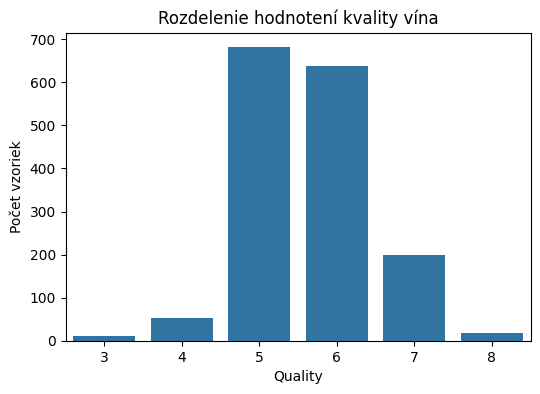

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="quality", data=df)
plt.title("Rozdelenie hodnotení kvality vína")
plt.xlabel("Quality")
plt.ylabel("Počet vzoriek")
plt.show()

Z grafu je vidieť, že väčšina vzoriek má stredné hodnotenia kvality – najviac vín je ohodnotených známkou 5 a 6. Vyššie hodnotenia (7 a 8) a veľmi nízke hodnotenia (3 a 4) sa vyskytujú podstatne menej často. Dataset je teda výrazne koncentrovaný v strede škály a extrémne kvalitné alebo veľmi nekvalitné vína sú zastúpené len málo

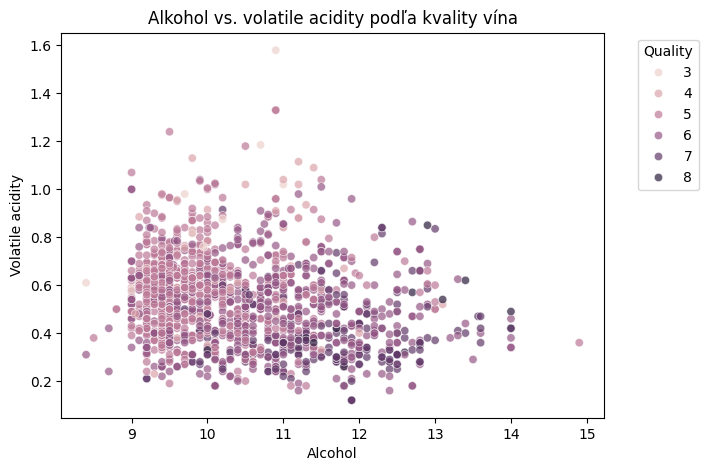

In [11]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="alcohol",
    y="volatile acidity",
    hue="quality",
    data=df,
    alpha=0.7
)
plt.title("Alkohol vs. volatile acidity podľa kvality vína")
plt.xlabel("Alcohol")
plt.ylabel("Volatile acidity")
plt.legend(title="Quality", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Z daného grafu je vidieť, ako spolu súvisia dve kľúčové premenné – obsah alkoholu a prchavá kyslosť – a zároveň, ako sa v tomto priestore rozkladajú jednotlivé triedy kvality vína. Body nevytvárajú úplne náhodný oblak, ale naznačujú skôr negatívny vzťah medzi týmito dvoma premennými: pri vyššom obsahu alkoholu sa väčšina vín nachádza pri nižších hodnotách prchavej kyslosti, zatiaľ čo pri nižšom alkohole sa častejšie vyskytujú vyššie hodnoty volatile acidity. Silnejšie vína tak majú skôr miernejšiu prchavú kyslosť, zatiaľ čo vyššia prchavá kyslosť je typickejšia pre slabšie vína.
Farebné odlíšenie podľa kvality ukazuje, že kvalita nie je v tomto priestore rozložená rovnomerne. Vína s vyšším hodnotením (7–8) sa koncentrujú najmä v oblasti vyššieho obsahu alkoholu (približne 11–13 %) a zároveň nižšej až strednej prchavej kyslosti (okolo 0,2–0,6). Naopak, vína s nižšou kvalitou (3–4) sa častejšie objavujú v kombinácii nižšieho alkoholu a vyššej prchavej kyslosti, neraz s hodnotami volatile acidity nad 0,6. Stredné hodnotenia kvality (5–6), ktorých je najviac, vypĺňajú veľkú časť stredu grafu a prekrývajú široký rozsah oboch premenných, čo naznačuje, že hranice medzi triedami kvality nie sú ostré, najmä v strede škály.
Z pohľadu interpretácie to znamená, že obsah alkoholu a prchavá kyslosť sú potenciálne dôležité indikátory kvality vína – vyšší alkohol a nižšia prchavá kyslosť sú typickejšie pre kvalitnejšie vína, zatiaľ čo opačná kombinácia je častejšia pri menej kvalitných. Zároveň však existuje pomerne veľké prekrytie medzi triedami, najmä medzi kvalitou 5 a 6, takže tieto dve premenné samostatne pravdepodobne nebudú stačiť na úplne presnú klasifikáciu, ale tvoria silný signál, ktorý by mal výrazne pomôcť pri modelovaní kvality vína.

===== Logistická regresia =====
Accuracy (test): 0.740625

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       149
           1       0.77      0.74      0.75       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320

Confusion matrix:
 [[111  38]
 [ 45 126]]


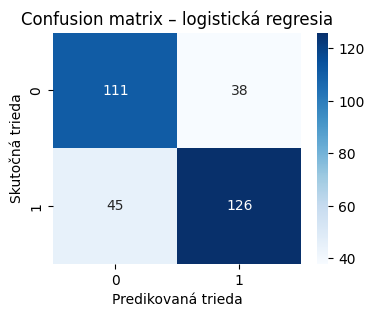


===== Random Forest =====
Accuracy (test): 0.809375

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       149
           1       0.83      0.81      0.82       171

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320

Confusion matrix:
 [[121  28]
 [ 33 138]]


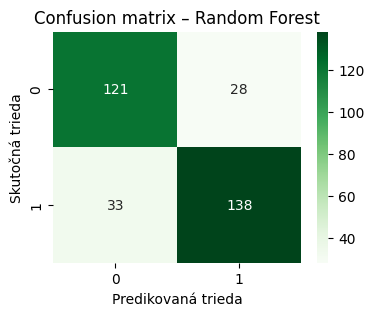

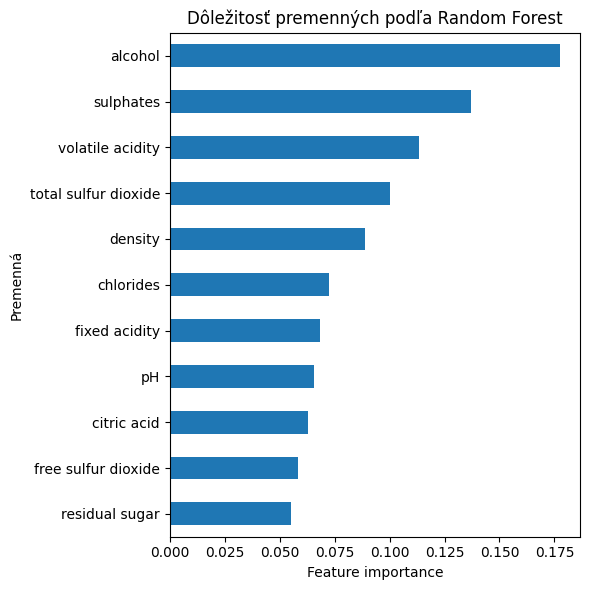


Top 10 najdôležitejších premenných podľa RF:
alcohol                 0.177728
sulphates               0.136851
volatile acidity        0.113564
total sulfur dioxide    0.100091
density                 0.088774
chlorides               0.072264
fixed acidity           0.068470
pH                      0.065669
citric acid             0.063083
free sulfur dioxide     0.058454
dtype: float64


In [12]:
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

# ============================================
# 2. Rozdelenie dát na train / test
# ============================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ============================================
# 3. Logistická regresia (baseline model)
# ============================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# natrénovanie modelu
logreg_pipeline.fit(X_train, y_train)

# predikcia na testovacej množine
y_pred_logreg = logreg_pipeline.predict(X_test)

print("===== Logistická regresia =====")
print("Accuracy (test):", accuracy_score(y_test, y_pred_logreg))
print("\nClassification report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_logreg))


# (voliteľné) grafická confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_logreg = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(4,3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix – logistická regresia")
plt.xlabel("Predikovaná trieda")
plt.ylabel("Skutočná trieda")
plt.show()


# ============================================
# 4. Random Forest classifier
# ============================================
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n===== Random Forest =====")
print("Accuracy (test):", accuracy_score(y_test, y_pred_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion matrix – Random Forest")
plt.xlabel("Predikovaná trieda")
plt.ylabel("Skutočná trieda")
plt.show()


# ============================================
# 5. Dôležitosť premenných (feature importance)
# ============================================
import pandas as pd

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(6,6))
importances_sorted.plot(kind="barh")
plt.title("Dôležitosť premenných podľa Random Forest")
plt.xlabel("Feature importance")
plt.ylabel("Premenná")
plt.tight_layout()
plt.show()

print("\nTop 10 najdôležitejších premenných podľa RF:")
print(importances.sort_values(ascending=False).head(10))

Na základe dosiahnutých výsledkov možno konštatovať, že jednoduchý lineárny model logistickej regresie dokáže zachytiť základný vzťah medzi chemickými vlastnosťami vína a jeho kvalitou a na testovacích dátach dosahuje presnosť približne 74 %. Nelineárny ansámblový model Random Forest však poskytuje výrazne lepší výkon – presnosť sa zvyšuje približne na 81 % a klesá aj počet nesprávnych klasifikácií v oboch triedach. Z hľadiska predikčnej schopnosti je preto vhodnejšie použiť Random Forest, aj za cenu nižšej interpretovateľnosti jednotlivých rozhodnutí. Analýza dôležitosti premenných zároveň ukazuje, že pre kvalitu vína sú kľúčové najmä obsah alkoholu, množstvo síranov a prchavá kyslosť, čo je v súlade so zisteniami z exploračnej analýzy.

# Porovnanie ML algoritmov 

c:\Users\szscb\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:41:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


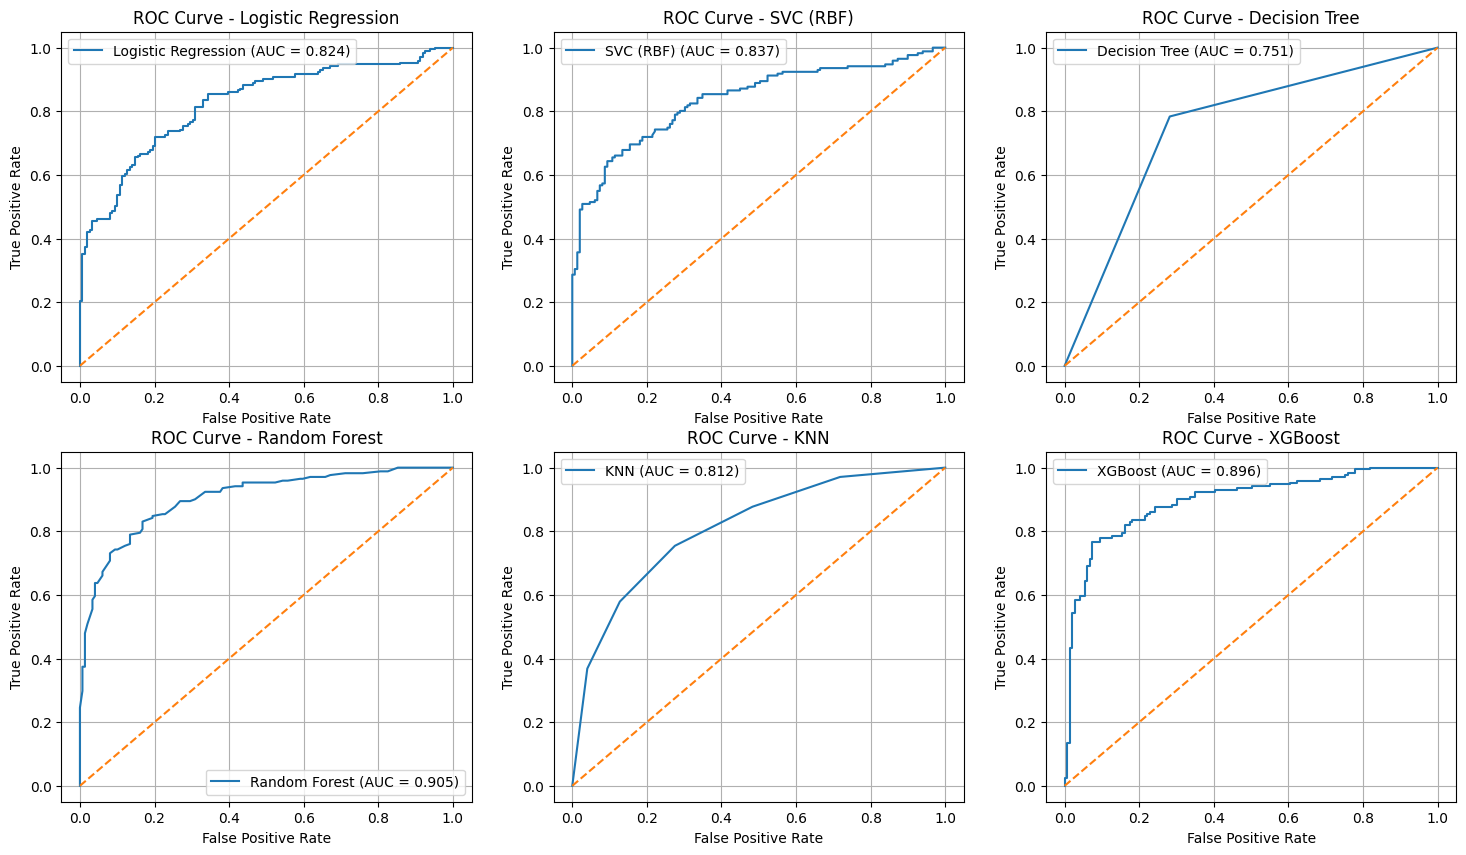

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
fig, axes = plt.subplots(2,3 , figsize=(18,10))
ax_flat = axes.flatten()
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVC (RBF)": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
i = 0
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Get probability predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot
    ax =ax_flat[i]
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    ax.plot([0,1], [0,1], linestyle="--")  # random guess line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - {name}")
    ax.legend()
    ax.grid(True)
    i += 1
plt.show()

Na porovnanie modelov sme okrem accuracy použili aj ROC krivky a metrikou AUC (Area Under Curve). ROC krivka zobrazuje závislosť medzi mierou správne identifikovaných pozitívnych prípadov (True Positive Rate) a mierou falošne pozitívnych klasifikácií (False Positive Rate) pri rôznych prahoch rozhodovania. Ideálny model má krivku čo najviac vytiahnutú k ľavému hornému rohu grafu, zatiaľ čo diagonála predstavuje náhodný klasifikátor. Hodnota AUC zachytáva plochu pod ROC krivkou a nadobúda hodnoty od 0,5 (náhodné rozhodovanie) po 1 (perfektná klasifikácia).

Porovnanie AUC ukazuje, že všetky testované modely majú rozumnú diskriminačnú schopnosť (AUC väčšie ako 0,8), pričom najlepšie výsledky dosiahol model Random Forest s AUC približne 0,90, veľmi podobne aj XGBoost s AUC okolo 0,90. Logistická regresia, SVC a KNN dosahujú AUC v rozmedzí 0,81–0,84 a samostatný rozhodovací strom je najslabší (AUC ≈ 0,75). Výsledky ROC analýzy tak potvrdzujú závery z accuracy – z testovaných algoritmov má najlepšiu schopnosť odlíšiť vína vyššej a nižšej kvality práve Random Forest (prípadne XGBoost), ktoré preto považujem za najvhodnejšie modely v tomto projekte.

# Optimalizácia parametrov 

In [14]:
param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [500]
    },
    
    "SVC": {
        "C": [0.1, 1, 3, 10],
        "kernel": ["rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    
    "Decision Tree": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    
    "Random Forest": {
        "n_estimators": [200, 400, 600],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
    },
    
    "KNN": {
        "n_neighbors": [3, 5, 7, 11, 15],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # Manhattan vs Euclidean
    },
    "XGBoost": {
        "n_estimators": [200, 400],
        "learning_rate": [0.03, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False)
}

results = []

for name in models:
    print(f"\nOptimizing {name} ...")
    
    grid = GridSearchCV(
        models[name],
        param_grids[name],
        scoring="accuracy",
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_
    test_accuracy = best_model.score(X_test, y_test)
    
    results.append([name, best_score, test_accuracy, best_params])



Optimizing Logistic Regression ...

Optimizing SVC ...

Optimizing Decision Tree ...

Optimizing Random Forest ...

Optimizing KNN ...

Optimizing XGBoost ...


c:\Users\szscb\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:43:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
results_df = pd.DataFrame(results, columns=[
    "Model", "Best CV Accuracy", "Test Accuracy", "Best Parameters"
])

results_df

,Model,Best CV Accuracy,Test Accuracy,Best Parameters
0,Logistic Regression,0.741229,0.737500,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l2', '..."
1,SVC,0.765447,0.759375,"{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}"
2,Decision Tree,0.745138,0.756250,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
3,Random Forest,0.810803,0.787500,"{'max_depth': 20, 'min_samples_split': 2, 'n_e..."
4,KNN,0.791256,0.812500,"{'n_neighbors': 15, 'p': 2, 'weights': 'distan..."
5,XGBoost,0.804556,0.825000,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


In [18]:
best_params = {}
for i, row in results_df.iterrows():
    best_params[row["Model"]] = row["Best Parameters"]
best_params

{'Logistic Regression': {'C': 0.1,
  'max_iter': 500,
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'SVC': {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'},
 'Decision Tree': {'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 'Random Forest': {'max_depth': 20,
  'min_samples_split': 2,
  'n_estimators': 400},
 'KNN': {'n_neighbors': 15, 'p': 2, 'weights': 'distance'},
 'XGBoost': {'colsample_bytree': 0.8,
  'learning_rate': 0.03,
  'max_depth': 7,
  'n_estimators': 200,
  'subsample': 0.8}}

c:\Users\szscb\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


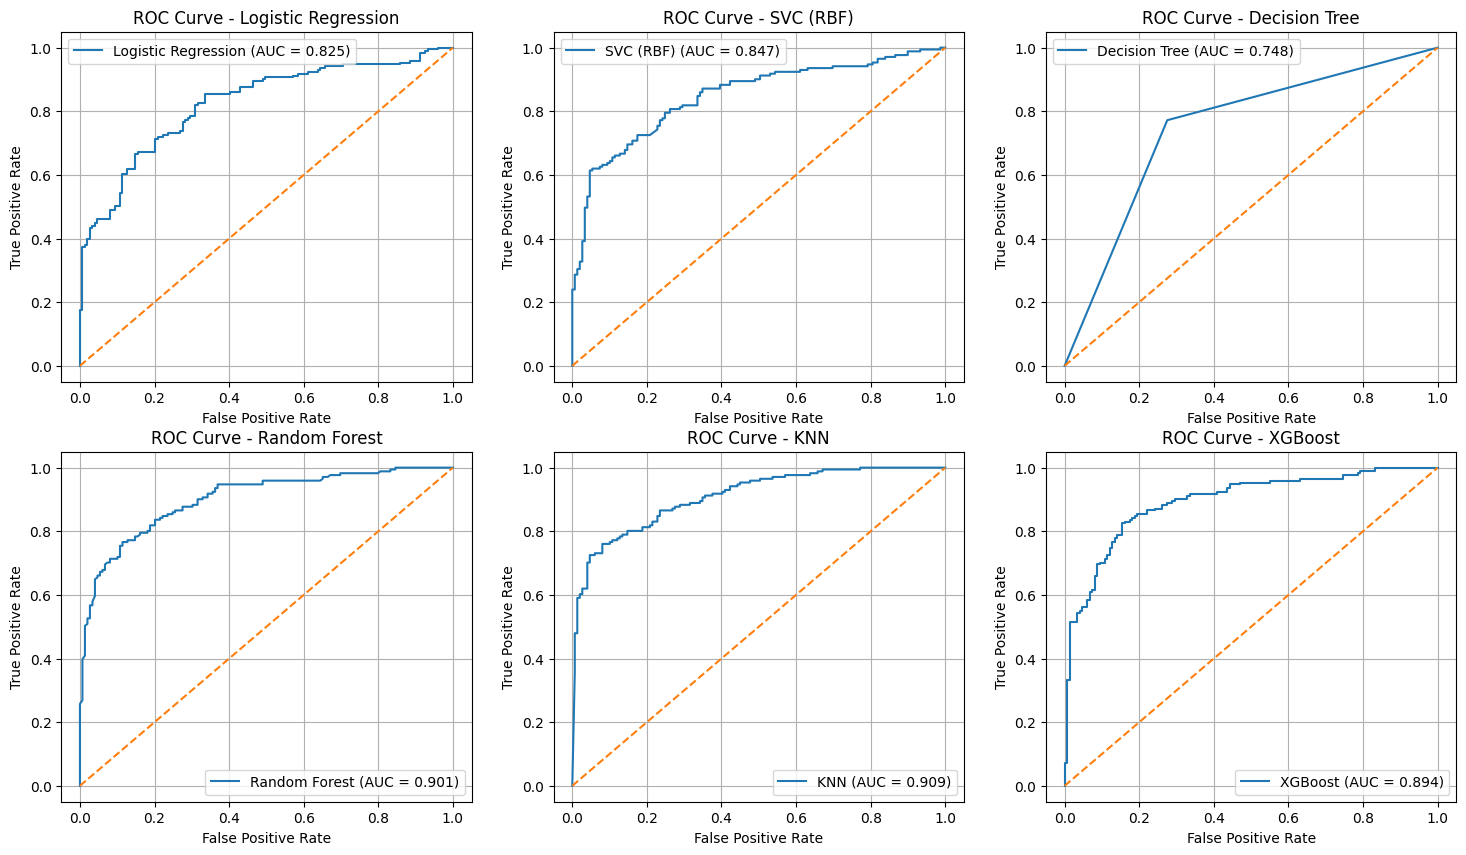

                     Accuracy  Acurracy from ROC
Logistic Regression  0.737500           0.824601
SVC (RBF)            0.759375           0.846913
Decision Tree        0.750000           0.748381
Random Forest        0.806250           0.901291
KNN                  0.812500           0.909239
XGBoost              0.825000           0.893795


In [19]:
### Final evaluation with best parameters  and ROC curves ###


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
accuracy_scores = {}
fig, axes = plt.subplots(2,3 , figsize=(18,10))
ax_flat = axes.flatten()
models = {
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "SVC (RBF)": SVC(probability = True, **best_params["SVC"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "KNN": KNeighborsClassifier(**best_params["KNN"]),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',**best_params["XGBoost"])
}
i = 0
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Get probability predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    accuracy_scores[name] = (model.score(X_test, y_test),auc)
    ax =ax_flat[i]
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    ax.plot([0,1], [0,1], linestyle="--")  # random guess line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - {name}")
    ax.legend()
    ax.grid(True)
    i += 1
plt.show()
accuracy_scores = pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=['Accuracy', 'Acurracy from ROC'])
print(accuracy_scores)

Pre jednotlivé modely som následne realizoval optimalizáciu hyperparametrov pomocou metódy GridSearchCV zo scikit-learn. Pre každý algoritmus som nadefinoval mriežku možných hodnôt (napr. počet stromov a maximálnu hĺbku pri Random Foreste, parameter 
𝐶
C a typ jadra pri SVC, počet susedov pri KNN, rýchlosť učenia a počet stromov pri XGBoost a pod.). GridSearchCV prechádza všetky kombinácie hyperparametrov, na tréningovej množine vykoná 5-násobnú krížovú validáciu a vyberie kombináciu s najvyššou priemernou presnosťou.

Výsledky optimalizácie sú zhrnuté v tabuľke s najlepšou krížovou presnosťou (Best CV Accuracy), presnosťou na testovacej množine (Test Accuracy) a zodpovedajúcimi optimálnymi parametrami. Optimalizácia viedla k miernemu zlepšeniu všetkých modelov. Najlepšie výsledky dosiahli modely Random Forest, K-nearest neighbors a XGBoost, ktoré dosahujú testovaciu presnosť približne 80–83 % a AUC v okolí 0,89–0,90. Naopak, samostatný rozhodovací strom vykazuje najnižší výkon aj po ladení parametrov, čo potvrdzuje výhodu ansámblových metód (Random Forest, XGBoost) a KNN oproti jednoduchým stromovým modelom.


#  Záver
V projekte sme sa zamerali na predikciu kvality červeného vína na základe jeho fyzikálno-chemických vlastností. Pôvodnú číselnú premennú quality sme previedli na binárnu cieľovú premennú, ktorá rozlišuje vína nižšej a vyššej kvality. Exploračná analýza ukázala, že dáta sú kompletné, väčšina premenných sa pohybuje v realistických rozsahoch pre víno a pri viacerých z nich (najmä residual sugar, sulphates, oxid siričitý) sa vyskytujú odľahlé hodnoty a zošikmené rozdelenia. Korelačná analýza a grafy naznačili, že kvalita vína súvisí najmä s obsahom alkoholu, prchavou kyslosťou, síranmi a oxidom siričitým – vyšší alkohol a vyššie hodnoty síranov sú typické skôr pre kvalitnejšie vína, zatiaľ čo zvýšená prchavá kyslosť a vyšší obsah chloridov sú skôr spojené s nižším hodnotením.

Na modelovanie sme použili viacero klasifikačných algoritmov (logistickú regresiu, SVC, rozhodovací strom, Random Forest, KNN a XGBoost) a ich hyperparametre sme ladili pomocou GridSearchCV. Výsledky ukázali, že všetky modely dosahujú na testovacej množine rozumnú presnosť, no najlepšie sa ukázali ansámblové a neparametrické metódy – najmä Random Forest, KNN a XGBoost, ktoré dosiahli testovaciu presnosť približne 80–83 % a hodnotu AUC okolo 0,89–0,90. Z hľadiska interpretácie a možností analýzy dôležitosti vstupných premenných sme za hlavný model zvolili Random Forest; ten potvrdil, že kľúčovými faktormi pre predikciu kvality sú najmä alcohol, sulphates a volatile acidity.